In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, countDistinct, size, row_number, explode, lit, when, udf, to_date, concat_ws, asc, desc, sum as _sum
)
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

# Initialize Spark session
spark = SparkSession.builder.appName("Project").getOrCreate()

#Load Data

In [0]:
profiles = spark.read.parquet('/dbfs/linkedin_people_train_data')


In [0]:
profiles.printSchema()

root
 |-- about: string (nullable = true)
 |-- avatar: string (nullable = true)
 |-- certifications: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- meta: string (nullable = true)
 |    |    |-- subtitle: string (nullable = true)
 |    |    |-- title: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- current_company: struct (nullable = true)
 |    |-- company_id: string (nullable = true)
 |    |-- industry: string (nullable = true)
 |    |-- link: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- title: string (nullable = true)
 |-- current_company:company_id: string (nullable = true)
 |-- current_company:name: string (nullable = true)
 |-- education: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- degree: string (nullable = true)
 |    |    |-- end_year: string (nullable = true)
 |    |    |-- field: string (nullable = true

%md
#Meta Industries

In [0]:
meta_industries_12 = {
    'Furniture and Home Furnishings Manufacturing': 'Manufacturing',
    'Investment Banking': 'Financial and Investment',
    'Ranching': 'Miscellaneous',
    'Hospitals and Health Care': 'Healthcare and Medical',
    'Computers and Electronics Manufacturing': 'Manufacturing',
    'Shipbuilding': 'Manufacturing',
    'Public Policy Offices': 'Government and Public Policy',
    'Software Development': 'Technology',
    'Retail Groceries': 'Retail and Consumer Goods',
    'Education Administration Programs': 'Education and Training',
    'Plastics Manufacturing': 'Manufacturing',
    'Renewable Energy Semiconductor Manufacturing': 'Manufacturing',
    'Computer Networking Products': 'Technology',
    'Semiconductor Manufacturing': 'Manufacturing',
    'Computer Hardware Manufacturing': 'Technology',
    'Maritime Transportation': 'Transportation and Logistics',
    'Tobacco Manufacturing': 'Manufacturing',
    'International Affairs': 'Government and Public Policy',
    'Spectator Sports': 'Miscellaneous',
    'Glass, Ceramics and Concrete Manufacturing': 'Manufacturing',
    'Chemical Manufacturing': 'Manufacturing',
    'Mining': 'Miscellaneous',
    'E-Learning Providers': 'Technology',
    'Automation Machinery Manufacturing': 'Technology',
    'Computer and Network Security': 'Technology',
    'Political Organizations': 'Government and Public Policy',
    'Oil and Gas': 'Miscellaneous',
    'Real Estate': 'Real Estate and Construction',
    'Think Tanks': 'Government and Public Policy',
    'Executive Offices': 'Miscellaneous',
    'Nanotechnology Research': 'Miscellaneous',
    'International Trade and Development': 'Government and Public Policy',
    'Personal Care Product Manufacturing': 'Manufacturing',
    'Entertainment Providers': 'Media and Entertainment',
    'Market Research': 'Media and Entertainment',
    'Movies, Videos, and Sound': 'Media and Entertainment',
    'Sporting Goods Manufacturing': 'Manufacturing',
    'Technology, Information and Internet': 'Technology',
    'Retail Office Equipment': 'Retail and Consumer Goods',
    'Capital Markets': 'Financial and Investment',
    'Freight and Package Transportation': 'Transportation and Logistics',
    'Industrial Machinery Manufacturing': 'Manufacturing',
    'Non-profit Organizations': 'Miscellaneous',
    'Retail Art Supplies': 'Retail and Consumer Goods',
    'Animation and Post-production': 'Media and Entertainment',
    'Transportation, Logistics, Supply Chain and Storage': 'Transportation and Logistics',
    'Aviation and Aerospace Component Manufacturing': 'Transportation and Logistics',
    'Fundraising': 'Financial and Investment',
    'Railroad Equipment Manufacturing': 'Transportation and Logistics',
    'Construction': 'Real Estate and Construction',
    'Investment Management': 'Financial and Investment',
    'Utilities': 'Miscellaneous',
    'Retail Luxury Goods and Jewelry': 'Retail and Consumer Goods',
    'Warehousing and Storage': 'Transportation and Logistics',
    'Media Production': 'Media and Entertainment',
    'Gambling Facilities and Casinos': 'Media and Entertainment',
    'Defense and Space Manufacturing': 'Manufacturing',
    'Paper and Forest Product Manufacturing': 'Manufacturing',
    'Packaging and Containers Manufacturing': 'Manufacturing',
    'Telecommunications': 'Technology',
    'Medical Equipment Manufacturing': 'Healthcare and Medical',
    'Beverage Manufacturing': 'Manufacturing',
    'Restaurants': 'Retail and Consumer Goods',
    'Leasing Non-residential Real Estate': 'Real Estate and Construction',
    'Newspaper Publishing': 'Media and Entertainment',
    'Armed Forces': 'Miscellaneous',
    'Appliances, Electrical, and Electronics Manufacturing': 'Manufacturing',
    'Pharmaceutical Manufacturing': 'Healthcare and Medical',
    'Retail Apparel and Fashion': 'Retail and Consumer Goods',
    'Photography': 'Media and Entertainment',
    'Truck Transportation': 'Transportation and Logistics',
    'Airlines and Aviation': 'Transportation and Logistics',
    'Machinery Manufacturing': 'Manufacturing',
    'Motor Vehicle Manufacturing': 'Manufacturing',
    'Performing Arts': 'Media and Entertainment',
    'Museums, Historical Sites, and Zoos': 'Media and Entertainment',
    'Broadcast Media Production and Distribution': 'Media and Entertainment',
    'Banking': 'Financial and Investment',
    'Recreational Facilities': 'Miscellaneous',
    'Government Administration': 'Government and Public Policy',
    #'Public Relations and Communications Services': 'Media and Entertainment',
    'Fisheries': 'Miscellaneous',
    'Medical Practices': 'Healthcare and Medical',
    'Religious Institutions': 'Miscellaneous',
    'Online Audio and Video Media': 'Media and Entertainment',
    'Artists and Writers': 'Miscellaneous',
    'Biotechnology Research': 'Healthcare and Medical',
    'Retail': 'Retail and Consumer Goods',
    'Libraries': 'Miscellaneous',
    'Alternative Dispute Resolution': 'Miscellaneous',
    'Manufacturing': 'Miscellaneous',
    'Dairy Product Manufacturing': 'Manufacturing',
    'Higher Education': 'Education and Training',
    'Civic and Social Organizations': 'Miscellaneous',
    'Textile Manufacturing': 'Manufacturing',
    'Venture Capital and Private Equity Principals': 'Financial and Investment',
    'Mental Health Care': 'Healthcare and Medical',
    'Musicians': 'Media and Entertainment',
    'Farming': 'Miscellaneous',
    'Computer Games': 'Media and Entertainment',
    'Food and Beverage Manufacturing': 'Manufacturing',
    'Primary and Secondary Education': 'Education and Training',
    'Alternative Medicine': 'Healthcare and Medical',
    'Mobile Gaming Apps': 'Media and Entertainment'
}

#EDA

In [0]:
print("Profiles count:", profiles.count())
profiles.select("current_company:company_id").distinct().show(10, truncate=False)
profiles.select(col("current_company:company_id")).distinct().show(10, truncate=False)
profiles.groupBy("current_company:company_id").count().filter(col("count") > 1).show()


Profiles count: 2768313
+-------------------------------------+
|current_company:company_id           |
+-------------------------------------+
|the-buckley-school-of-public-speaking|
|golden-west-college                  |
|jay-pink-solutions                   |
|mwiorg                               |
|first-colony-mortgage                |
|kkr                                  |
|centennial-public-school             |
|seattle-university                   |
|university-of-rochester              |
|everiseglobal                        |
+-------------------------------------+
only showing top 10 rows

+-------------------------------------+
|current_company:company_id           |
+-------------------------------------+
|the-buckley-school-of-public-speaking|
|golden-west-college                  |
|jay-pink-solutions                   |
|mwiorg                               |
|first-colony-mortgage                |
|kkr                                  |
|centennial-public-school     

In [0]:
from pyspark.sql.functions import col, regexp_extract, count

# Exploding the "experience" column into nested data
exploded_profiles = profiles.withColumn("exploded_experience", explode(col("experience")))

# Extracting the year from "start_date" using REGEX
year_regex = r"(\d{4})"  
profiles_with_year = exploded_profiles.withColumn(
    "start_year",
    regexp_extract(col("exploded_experience.start_date"), year_regex, 1).cast("int")
)

# Filtering only observations with a non-null start_year
filtered_profiles = profiles_with_year.filter(col("start_year").isNotNull())

# Grouping data by start_year
yearly_counts = filtered_profiles.groupBy("start_year") \
    .agg(count("id").alias("profiles_count")) \
    .orderBy("start_year")

# Displaying the result
yearly_counts.display()


start_year,profiles_count
1900,209
1901,85
1902,7
1903,4
1904,7
1905,5
1906,5
1907,3
1908,10
1909,6


In [0]:
# Filtering rows with a non-null start_year
cleaned_profiles = profiles_with_year.filter(col("start_year").isNotNull())

# Filtering rows with a non-null job_title
cleaned_profiles = cleaned_profiles.filter(col("exploded_experience.title").isNotNull())


#Cleaning not only in num of charcters

In [0]:
from pyspark.sql.functions import count

popular_roles_over_time = cleaned_profiles.groupBy("start_year", "exploded_experience.title") \
    .agg(count("id").alias("profiles_count")) \
    .orderBy("start_year", col("profiles_count").desc())

popular_roles_over_time.show(truncate=False)


+----------+-----------------------------------+--------------+
|start_year|title                              |profiles_count|
+----------+-----------------------------------+--------------+
|1900      |Owner                              |7             |
|1900      |None                               |3             |
|1900      |-                                  |3             |
|1900      |x                                  |2             |
|1900      |Manager                            |2             |
|1900      |na                                 |2             |
|1900      |IT Project Manager                 |2             |
|1900      |Accupuncturist                     |1             |
|1900      |مستشار اول                         |1             |
|1900      |Equities Derivative Trading        |1             |
|1900      |Sculptural Artist                  |1             |
|1900      |Distributor Services               |1             |
|1900      |Membership                  

In [0]:
from pyspark.sql.functions import lit
from pyspark.sql import Row

meta_industries_rows = [Row(industry=key, meta_industry=value) for key, value in meta_industries_12.items()]
meta_industries_df = spark.createDataFrame(meta_industries_rows)

meta_industries_df.show(truncate=False)


+--------------------------------------------+----------------------------+
|industry                                    |meta_industry               |
+--------------------------------------------+----------------------------+
|Furniture and Home Furnishings Manufacturing|Manufacturing               |
|Investment Banking                          |Financial and Investment    |
|Ranching                                    |Miscellaneous               |
|Hospitals and Health Care                   |Healthcare and Medical      |
|Computers and Electronics Manufacturing     |Manufacturing               |
|Shipbuilding                                |Manufacturing               |
|Public Policy Offices                       |Government and Public Policy|
|Software Development                        |Technology                  |
|Retail Groceries                            |Retail and Consumer Goods   |
|Education Administration Programs           |Education and Training      |
|Plastics Ma

In [0]:
# Joining the mapping table to the profiles table
profiles_with_meta = profiles_with_year.alias("p").join(
    meta_industries_df.alias("m"),
    col("p.exploded_experience.title") == col("m.industry"),
    "left"
).select(
    col("p.start_year"),
    col("p.exploded_experience.title").alias("job_title"),
    col("m.meta_industry")  # Defined industry category
)

# Filtering out records without an industry mapping
profiles_with_meta = profiles_with_meta.filter(col("meta_industry").isNotNull())

# Displaying the joined data
profiles_with_meta.show(10, truncate=False)

profiles_with_meta.display()


+----------+---------------------+----------------------------+
|start_year|job_title            |meta_industry               |
+----------+---------------------+----------------------------+
|2014      |Construction         |Real Estate and Construction|
|2003      |Real Estate          |Real Estate and Construction|
|1990      |Manufacturing        |Miscellaneous               |
|NULL      |Retail               |Retail and Consumer Goods   |
|2001      |Market Research      |Media and Entertainment     |
|NULL      |Real Estate          |Real Estate and Construction|
|2015      |Manufacturing        |Miscellaneous               |
|2016      |Investment Management|Financial and Investment    |
|1985      |Manufacturing        |Miscellaneous               |
|1999      |Farming              |Miscellaneous               |
+----------+---------------------+----------------------------+
only showing top 10 rows



start_year,job_title,meta_industry
2014,Construction,Real Estate and Construction
2003,Real Estate,Real Estate and Construction
1990,Manufacturing,Miscellaneous
null,Retail,Retail and Consumer Goods
2001,Market Research,Media and Entertainment
null,Real Estate,Real Estate and Construction
2015,Manufacturing,Miscellaneous
2016,Investment Management,Financial and Investment
1985,Manufacturing,Miscellaneous
1999,Farming,Miscellaneous


#cleaning nulls

In [0]:
from pyspark.sql.functions import count

# Grouping data by meta_industry and year
industry_trends = profiles_with_meta.groupBy("meta_industry", "start_year") \
    .agg(count("job_title").alias("profiles_count")) \
    .orderBy("meta_industry", "start_year")

# Displaying the results
industry_trends.show(truncate=False)


+------------------------+----------+--------------+
|meta_industry           |start_year|profiles_count|
+------------------------+----------+--------------+
|Education and Training  |NULL      |3             |
|Education and Training  |2011      |1             |
|Education and Training  |2021      |1             |
|Financial and Investment|NULL      |25            |
|Financial and Investment|1962      |1             |
|Financial and Investment|1969      |1             |
|Financial and Investment|1970      |1             |
|Financial and Investment|1972      |1             |
|Financial and Investment|1973      |1             |
|Financial and Investment|1974      |1             |
|Financial and Investment|1976      |1             |
|Financial and Investment|1978      |1             |
|Financial and Investment|1979      |2             |
|Financial and Investment|1981      |1             |
|Financial and Investment|1983      |1             |
|Financial and Investment|1986      |1        

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

# Defining a window for each industry ordered by year
window_spec = Window.partitionBy("meta_industry").orderBy("start_year")

# Adding a column to track the change in the number of profiles year over year
industry_trends_with_growth = industry_trends.withColumn(
    "yearly_growth",
    col("profiles_count") - lag("profiles_count").over(window_spec)
)  # yearly_growth represents the number of employees added to the industry in the following year

# Filtering industries with a growth trend
growing_industries = industry_trends_with_growth.filter(col("yearly_growth") > 0)

# Displaying growing industries
growing_industries.show(truncate=False)


+------------------------+----------+--------------+-------------+
|meta_industry           |start_year|profiles_count|yearly_growth|
+------------------------+----------+--------------+-------------+
|Financial and Investment|1979      |2             |1            |
|Financial and Investment|1988      |2             |1            |
|Financial and Investment|1990      |3             |1            |
|Financial and Investment|1996      |4             |3            |
|Financial and Investment|1999      |3             |2            |
|Financial and Investment|2003      |4             |2            |
|Financial and Investment|2005      |2             |1            |
|Financial and Investment|2006      |6             |4            |
|Financial and Investment|2008      |5             |2            |
|Financial and Investment|2010      |7             |4            |
|Financial and Investment|2012      |7             |1            |
|Financial and Investment|2014      |9             |2         

# First Question
Which industries are growing at the fastest rate over the years?

Comparing the yearly growth rate (`yearly_growth`) across industries to identify the fastest-growing industries.
Creating a graph that displays the average growth rate of each industry.


In [0]:
from pyspark.sql.functions import avg

# Calculating the average growth for each industry
average_growth_by_industry = growing_industries.groupBy("meta_industry").agg(
    avg("yearly_growth").alias("average_growth")
).orderBy("average_growth", ascending=False)

# Displaying the data
average_growth_by_industry.show()


+--------------------+------------------+
|       meta_industry|    average_growth|
+--------------------+------------------+
|Real Estate and C...|               3.5|
|Retail and Consum...| 2.411764705882353|
|Financial and Inv...|               2.4|
|          Technology|1.8461538461538463|
|       Miscellaneous|1.8333333333333333|
|Media and Enterta...|1.5555555555555556|
+--------------------+------------------+



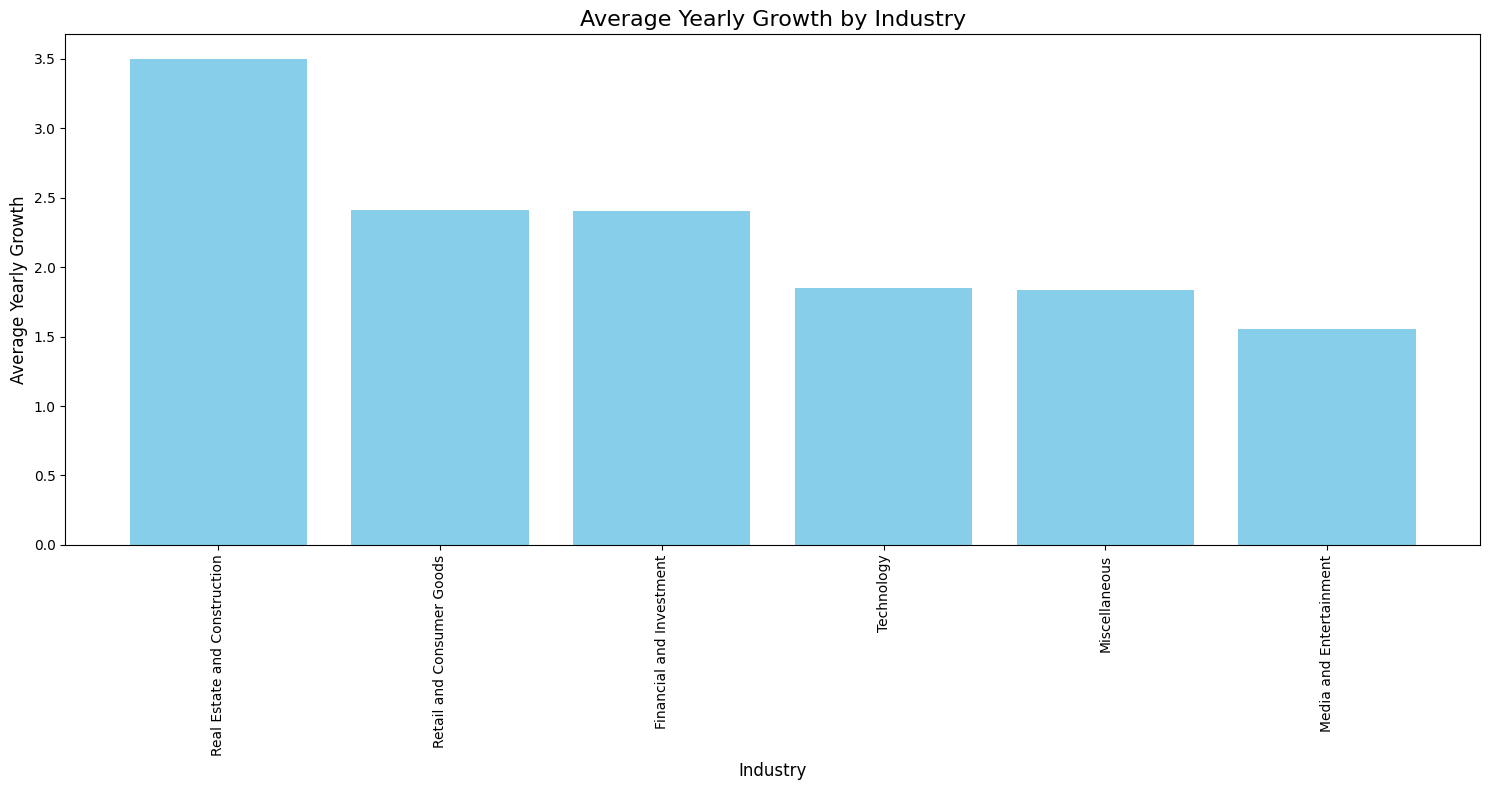

In [0]:
import matplotlib.pyplot as plt

# Converting the data to Pandas for plotting
data_for_plot = average_growth_by_industry.toPandas()

# Bar chart displaying the average yearly growth rate
plt.figure(figsize=(15, 8))
plt.bar(data_for_plot["meta_industry"], data_for_plot["average_growth"], color="skyblue")
plt.xticks(rotation=90)
plt.title("Average Yearly Growth by Industry", fontsize=16)
plt.xlabel("Industry", fontsize=12)
plt.ylabel("Average Yearly Growth", fontsize=12)
plt.tight_layout()
plt.show()


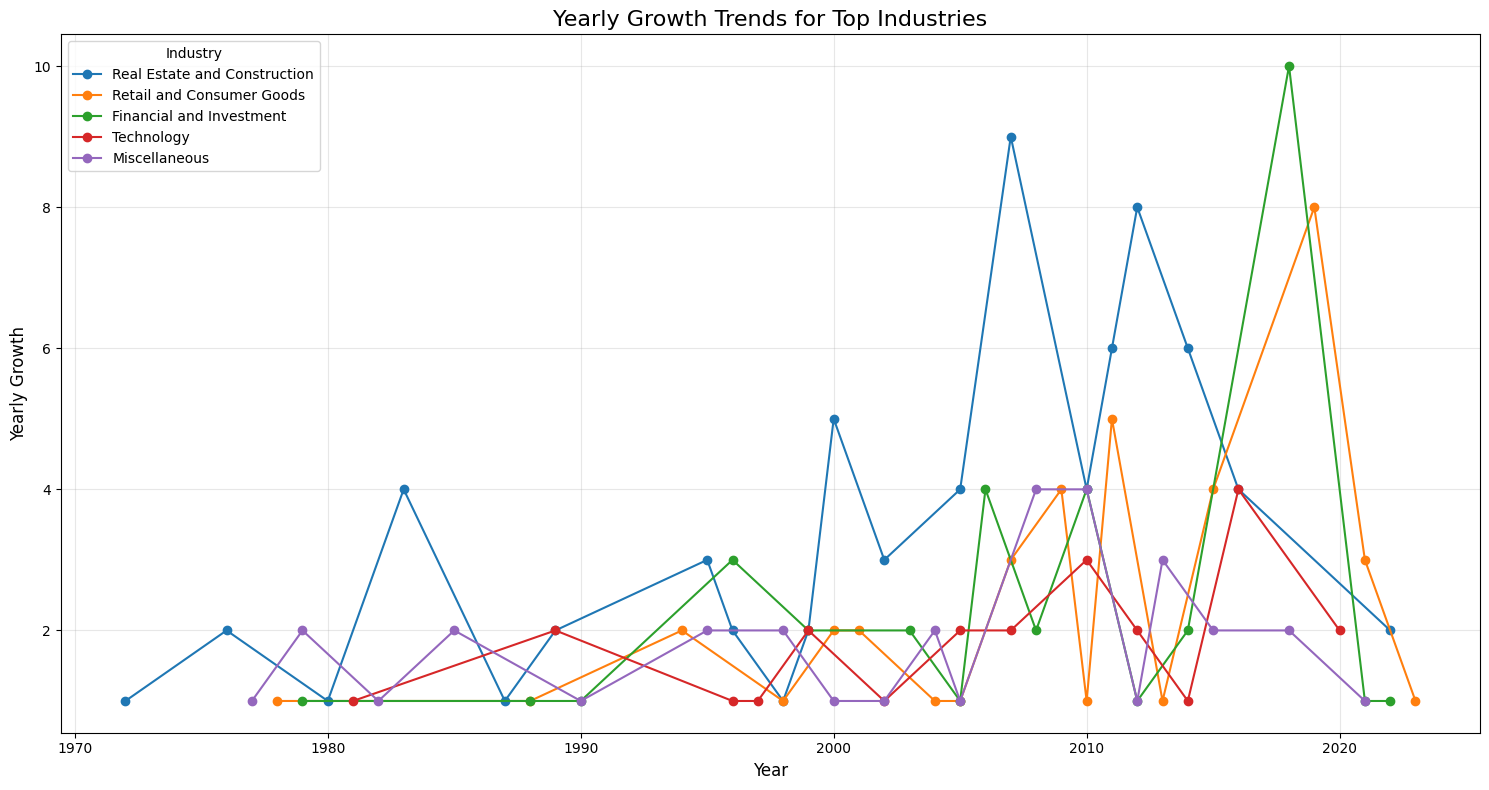

In [0]:
import matplotlib.pyplot as plt

# Filtering top industries based on average growth
top_industries = average_growth_by_industry.limit(5).select("meta_industry").rdd.flatMap(lambda x: x).collect()

# Filtering data for top industries
filtered_data = growing_industries.filter(col("meta_industry").isin(top_industries))

# Converting the data to Pandas for plotting
data_for_plot = filtered_data.toPandas()

# Line chart displaying growth trends for top industries
plt.figure(figsize=(15, 8))
for industry in top_industries:
    industry_data = data_for_plot[data_for_plot["meta_industry"] == industry]
    plt.plot(
        industry_data["start_year"], industry_data["yearly_growth"], 
        marker="o", label=industry
    )

plt.title("Yearly Growth Trends for Top Industries", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Yearly Growth", fontsize=12)
plt.legend(title="Industry", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


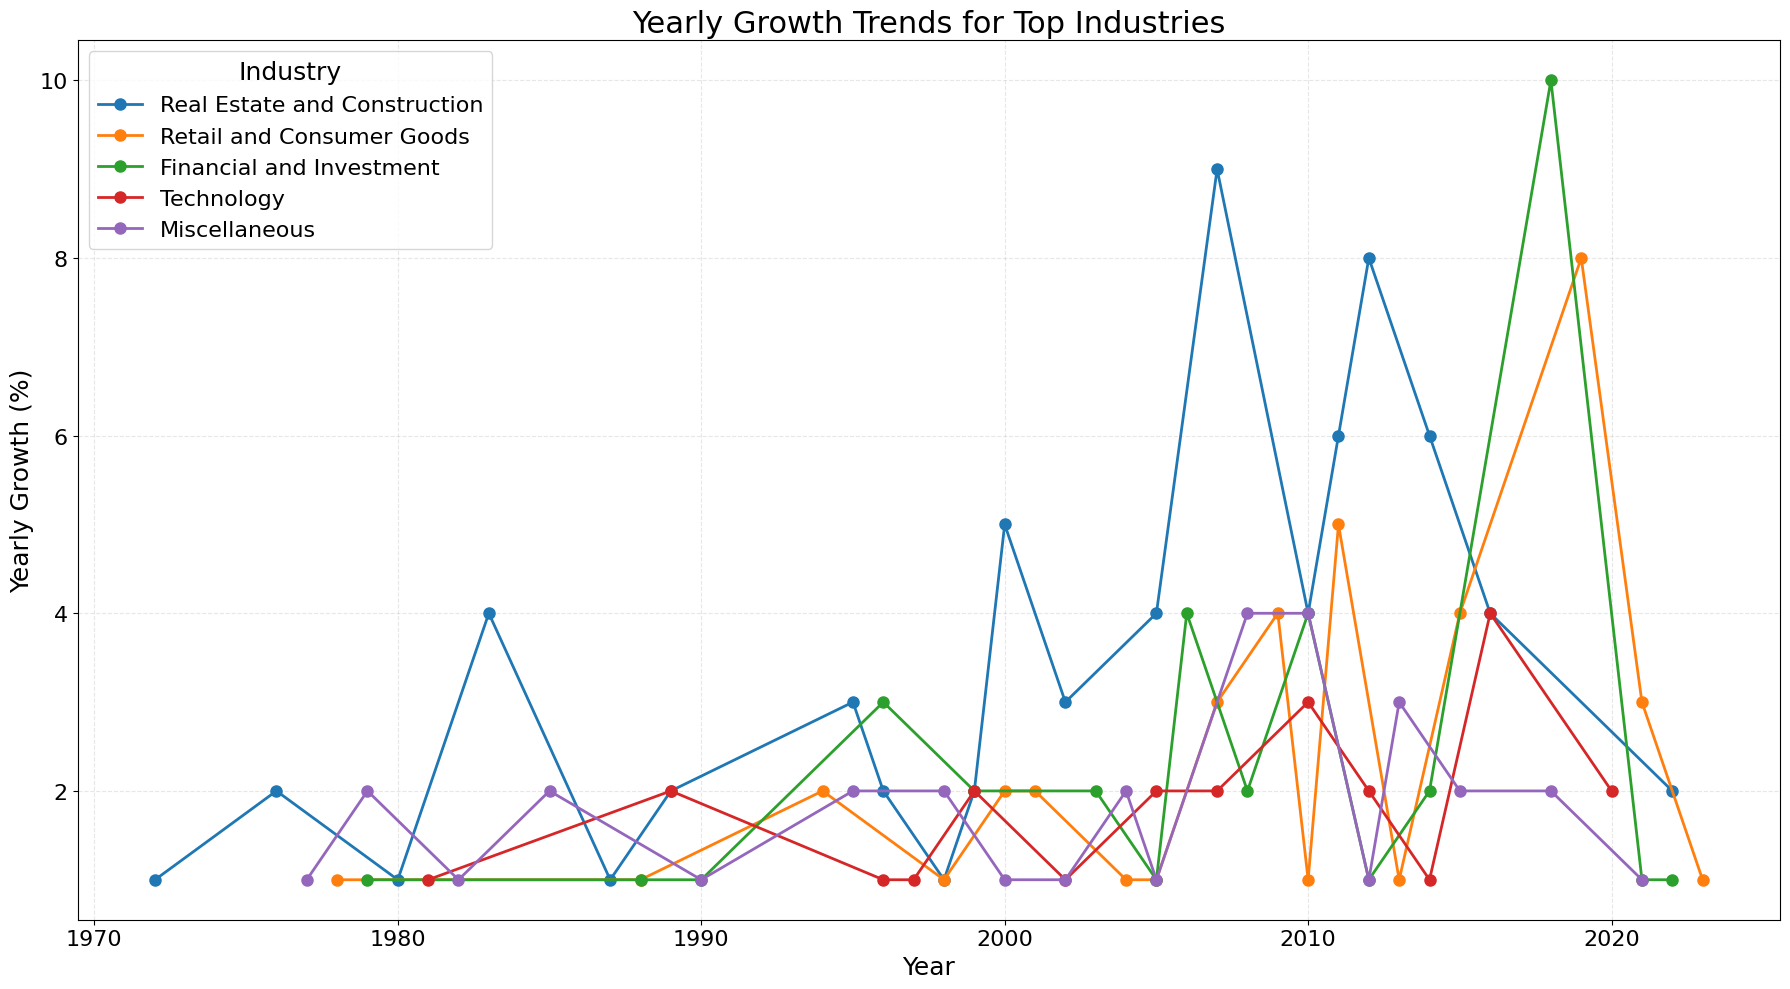

In [0]:
import matplotlib.pyplot as plt

# Filtering top industries based on average growth
top_industries = average_growth_by_industry.limit(5).select("meta_industry").rdd.flatMap(lambda x: x).collect()

# Filtering data for top industries
filtered_data = growing_industries.filter(col("meta_industry").isin(top_industries))

# Converting the data to Pandas for plotting
data_for_plot = filtered_data.toPandas()


font_size = 18

# Line chart displaying growth trends for top industries
plt.figure(figsize=(18, 10))
for industry in top_industries:
    industry_data = data_for_plot[data_for_plot["meta_industry"] == industry]
    plt.plot(
        industry_data["start_year"], industry_data["yearly_growth"], 
        marker="o", linestyle="-", linewidth=2, markersize=8, label=industry
    )

# Customizing and enhancing the chart
plt.title("Yearly Growth Trends for Top Industries", fontsize=font_size+4)
plt.xlabel("Year", fontsize=font_size)
plt.ylabel("Yearly Growth (%)", fontsize=font_size)
plt.xticks(fontsize=font_size-2)
plt.yticks(fontsize=font_size-2)
plt.legend(title="Industry", fontsize=font_size-2, title_fontsize=font_size)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


%md

####Which industry has the highest number of new profiles added in a given year?

Identifying the years in which industries experienced the highest number of new profiles (`profiles_count`).
Creating a graph that displays the number of new profiles over the years for specific industries.


In [0]:
from pyspark.sql.functions import col, desc

# Identifying the year with the highest number of new profiles for each industry
max_profiles_per_year = growing_industries.groupBy("meta_industry", "start_year") \
    .agg(_sum("profiles_count").alias("total_profiles")) \
    .orderBy(desc("total_profiles"))

# Displaying the data
max_profiles_per_year.show(truncate=False)


+----------------------------+----------+--------------+
|meta_industry               |start_year|total_profiles|
+----------------------------+----------+--------------+
|Real Estate and Construction|2012      |25            |
|Real Estate and Construction|2014      |21            |
|Real Estate and Construction|2007      |18            |
|Real Estate and Construction|2016      |18            |
|Real Estate and Construction|2011      |17            |
|Financial and Investment    |2018      |16            |
|Retail and Consumer Goods   |2011      |16            |
|Retail and Consumer Goods   |2013      |14            |
|Retail and Consumer Goods   |2019      |12            |
|Real Estate and Construction|2000      |11            |
|Real Estate and Construction|2010      |11            |
|Retail and Consumer Goods   |2010      |11            |
|Retail and Consumer Goods   |2015      |10            |
|Real Estate and Construction|2005      |10            |
|Miscellaneous               |2

In [0]:
from pyspark.sql.functions import col, desc, first

# Identify the industry with the highest number of profiles for each year
industry_with_max_profiles = max_profiles_per_year \
    .withColumn("rank", row_number().over(Window.partitionBy("start_year").orderBy(desc("total_profiles")))) \
    .filter(col("rank") == 1) \
    .select("start_year", "meta_industry", "total_profiles")

# Display the data
industry_with_max_profiles.show(truncate=False)


+----------+----------------------------+--------------+
|start_year|meta_industry               |total_profiles|
+----------+----------------------------+--------------+
|1972      |Real Estate and Construction|2             |
|1976      |Real Estate and Construction|3             |
|1977      |Miscellaneous               |2             |
|1978      |Retail and Consumer Goods   |2             |
|1979      |Miscellaneous               |3             |
|1980      |Real Estate and Construction|3             |
|1981      |Technology                  |2             |
|1982      |Miscellaneous               |2             |
|1983      |Real Estate and Construction|5             |
|1985      |Miscellaneous               |3             |
|1987      |Real Estate and Construction|2             |
|1988      |Financial and Investment    |2             |
|1989      |Real Estate and Construction|4             |
|1990      |Financial and Investment    |3             |
|1994      |Retail and Consumer

<Figure size 640x480 with 1 Axes>

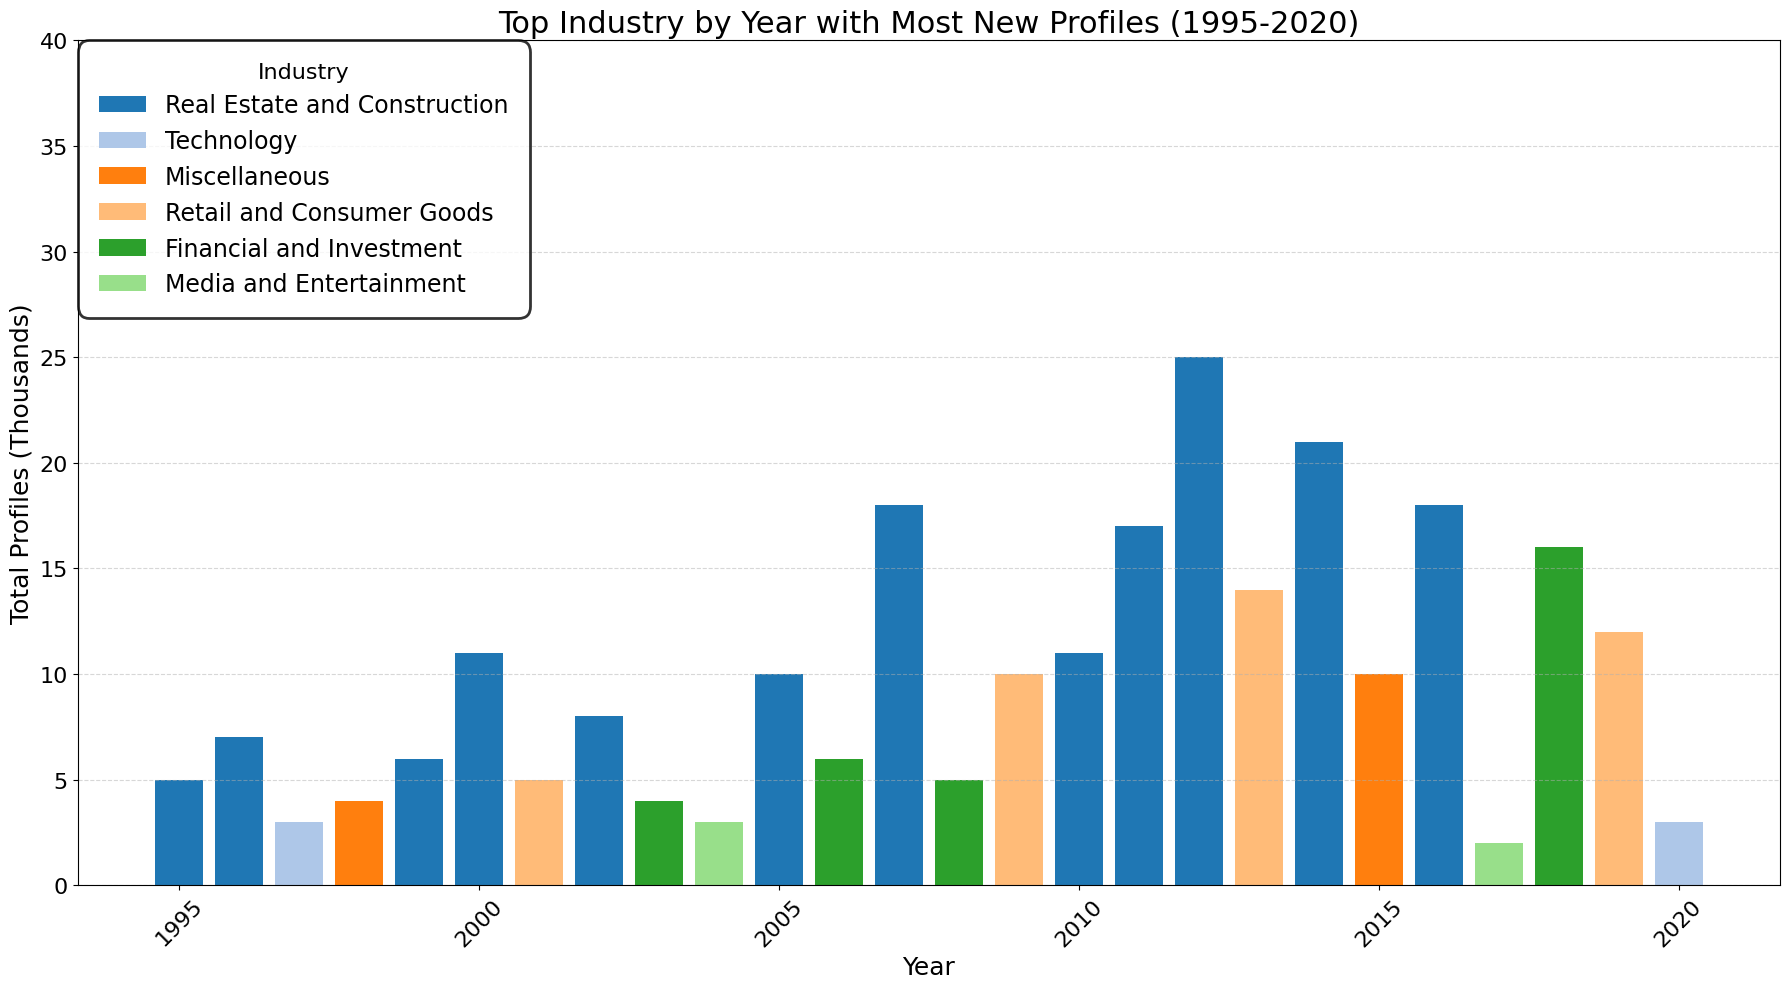

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert data to Pandas for visualization
data_for_plot = industry_with_max_profiles.toPandas()

# Annotate industry names on the plot
for index, row in data_for_plot.iterrows():
    plt.text(row["start_year"], row["total_profiles"], row["meta_industry"], 
             ha='center', va='bottom', fontsize=9, rotation=90)

# Filter data between 1995 and 2020
data_filtered = data_for_plot[(data_for_plot["start_year"] >= 1995) & (data_for_plot["start_year"] <= 2020)]

# Check if there is data available for the selected years
if data_filtered.empty:
    print("No data available for the selected years (1995-2020). Consider adjusting the range.")
else:
    # Assign unique colors to each industry
    industries = data_filtered["meta_industry"].unique()
    palette = sns.color_palette("tab20", len(industries))
    industry_colors = {industry: palette[i] for i, industry in enumerate(industries)}

    
    font_size = 18

    # Create bar chart
    plt.figure(figsize=(18, 10))
    for industry in industries:
        industry_data = data_filtered[data_filtered["meta_industry"] == industry]
        plt.bar(
            industry_data["start_year"],
            industry_data["total_profiles"],
            color=industry_colors[industry],
            label=industry if industry not in plt.gca().get_legend_handles_labels()[1] else ""
        )

    # Customizing and enhancing the chart
    plt.title("Top Industry by Year with Most New Profiles (1995-2020)", fontsize=font_size + 4)
    plt.xlabel("Year", fontsize=font_size)
    plt.ylabel("Total Profiles (Thousands)", fontsize=font_size)
    plt.xticks(fontsize=font_size-2, rotation=45)
    plt.yticks(fontsize=font_size-2)
    plt.ylim(0, 40)  # Set Y-axis limit to 40

    # Add legend inside the plot
    legend = plt.legend(title="Industry", fontsize=font_size-1, title_fontsize=font_size-2, loc='upper left', frameon=True)

    # Adjust legend box appearance
    frame = legend.get_frame()
    frame.set_linewidth(2)
    frame.set_edgecolor("black")
    frame.set_boxstyle("round,pad=0.5")

    # Add Y-axis grid for readability
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Display the plot
    plt.tight_layout()
    plt.show()


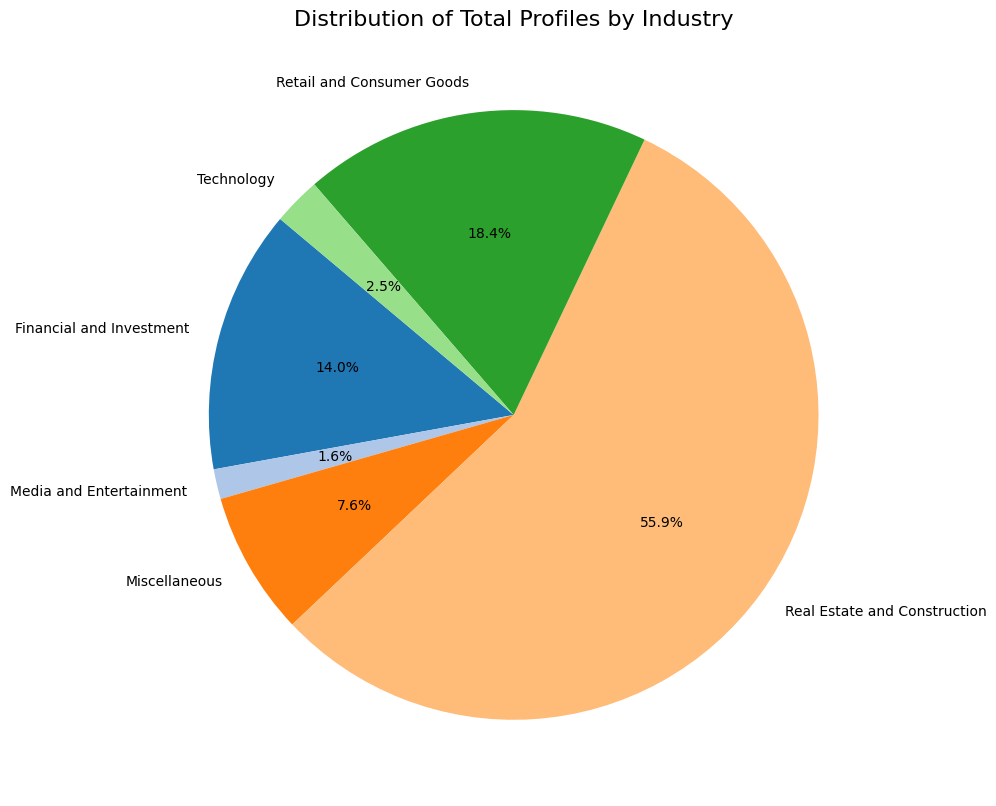

In [0]:
# Calculating the total number of profiles for each industry
industry_totals = data_for_plot.groupby("meta_industry")["total_profiles"].sum().reset_index()

# Creating a pie chart
plt.figure(figsize=(10, 10))
plt.pie(
    industry_totals["total_profiles"],
    labels=industry_totals["meta_industry"],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("tab20", len(industry_totals))
)

# Adjusting the title
plt.title("Distribution of Total Profiles by Industry", fontsize=16)
plt.tight_layout()
plt.show()


%md
Are there periods of decline or slowdown in certain industries?

Identifying industries that have shown a decline in the number of new profiles or in their yearly growth rate.


In [0]:
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window

# Define a window specification for calculating differences between years
window_spec = Window.partitionBy("meta_industry").orderBy("start_year")

# Add a column for the change in the number of profiles compared to the previous year
industries_with_trends = growing_industries.withColumn(
    "profiles_change",
    col("profiles_count") - lag("profiles_count", 1).over(window_spec)
)

# Filter industries with a decline in the number of profiles
industries_with_decline = industries_with_trends.filter(col("profiles_change") < 0)

# Display the result
industries_with_decline.show(truncate=False)


+----------------------------+----------+--------------+-------------+---------------+
|meta_industry               |start_year|profiles_count|yearly_growth|profiles_change|
+----------------------------+----------+--------------+-------------+---------------+
|Financial and Investment    |1999      |3             |2            |-1             |
|Financial and Investment    |2005      |2             |1            |-2             |
|Financial and Investment    |2008      |5             |2            |-1             |
|Financial and Investment    |2021      |7             |1            |-9             |
|Media and Entertainment     |2007      |2             |1            |-1             |
|Media and Entertainment     |2013      |3             |1            |-4             |
|Media and Entertainment     |2017      |2             |1            |-1             |
|Miscellaneous               |1982      |2             |1            |-1             |
|Miscellaneous               |1990      |2 

In [0]:
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window

# Defining a window to compute year-over-year differences
window_spec = Window.partitionBy("meta_industry").orderBy("start_year")

# Adding a column to calculate the change in the number of profiles compared to the previous year
industries_with_trends = growing_industries.withColumn(
    "profiles_change",
    col("profiles_count") - lag("profiles_count", 1).over(window_spec)
)

# Filtering industries that experienced a decline in the number of profiles
industries_with_decline = industries_with_trends.filter(col("profiles_change") < 0)

# Displaying the result
industries_with_decline.show(truncate=False)


+----------------------------+----------+--------------+-------------+---------------+
|meta_industry               |start_year|profiles_count|yearly_growth|profiles_change|
+----------------------------+----------+--------------+-------------+---------------+
|Financial and Investment    |1999      |3             |2            |-1             |
|Financial and Investment    |2005      |2             |1            |-2             |
|Financial and Investment    |2008      |5             |2            |-1             |
|Financial and Investment    |2021      |7             |1            |-9             |
|Media and Entertainment     |2007      |2             |1            |-1             |
|Media and Entertainment     |2013      |3             |1            |-4             |
|Media and Entertainment     |2017      |2             |1            |-1             |
|Miscellaneous               |1982      |2             |1            |-1             |
|Miscellaneous               |1990      |2 

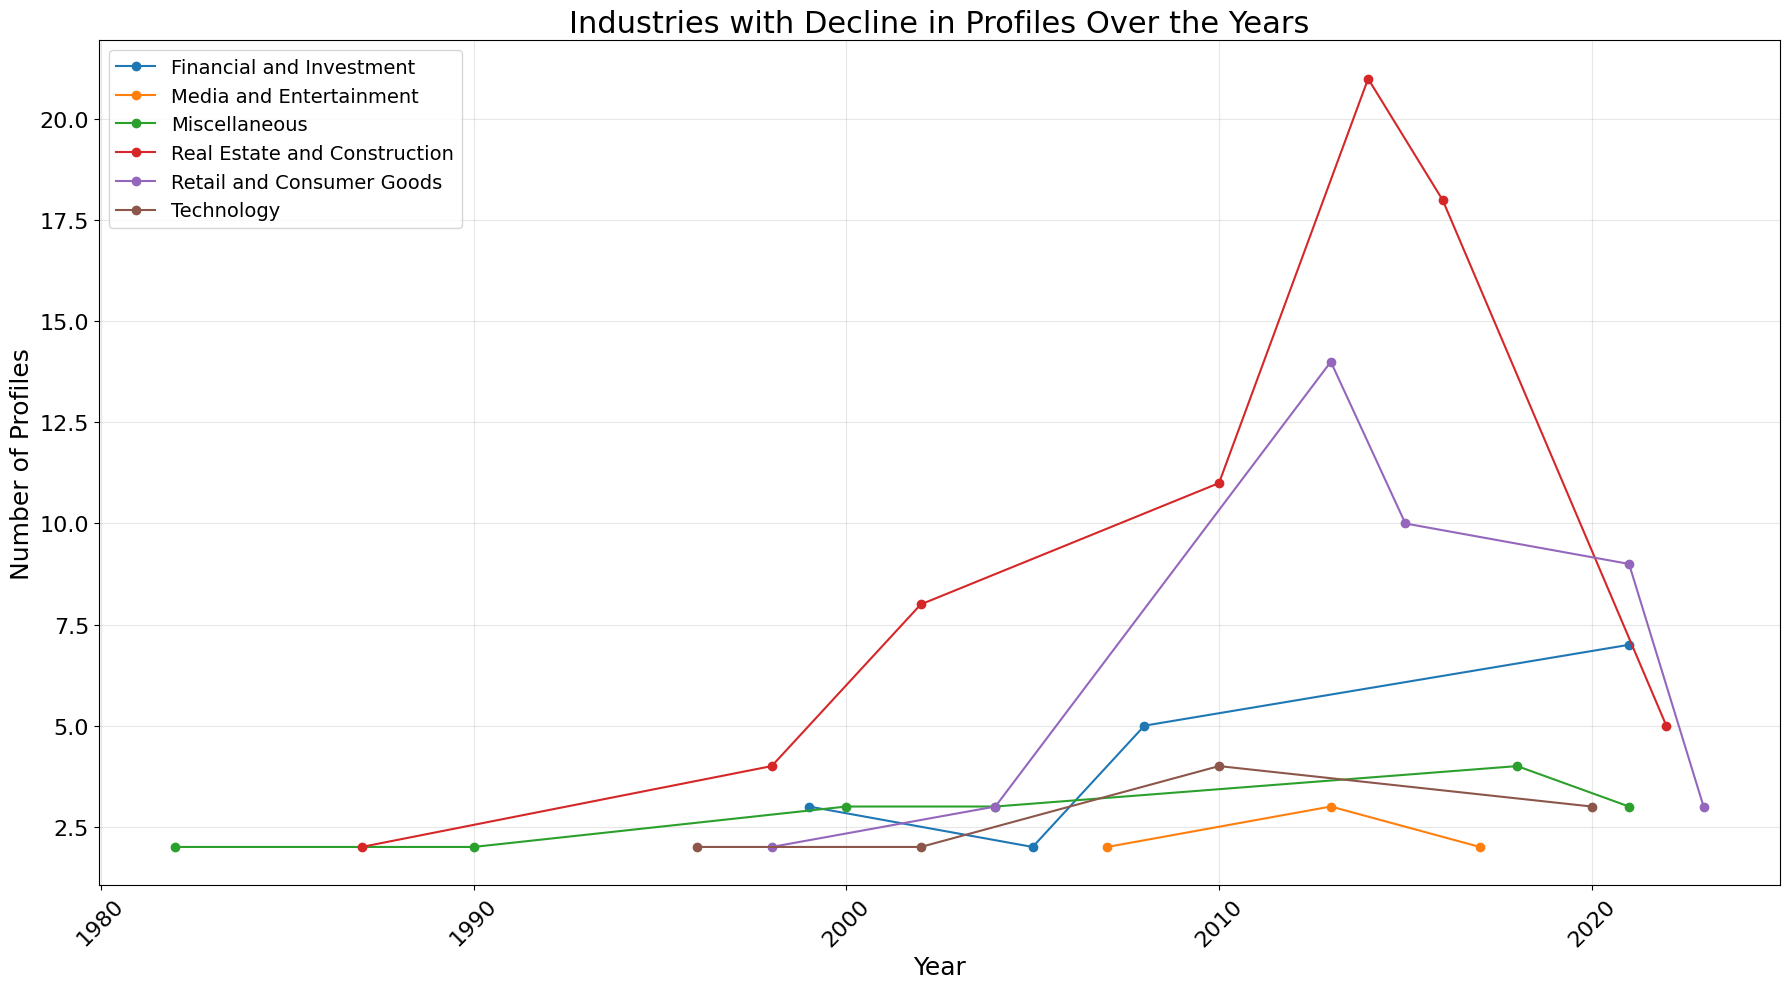

In [0]:
import matplotlib.pyplot as plt

# Convert data to Pandas for plotting
decline_data = industries_with_decline.toPandas()


font_size = 18

# Create a line plot for each industry
plt.figure(figsize=(18, 10))
for industry in decline_data["meta_industry"].unique():  # Iterate over each unique industry
    industry_data = decline_data[decline_data["meta_industry"] == industry]  # Filter data for the industry
    plt.plot(
        industry_data["start_year"],  # X-axis: Year
        industry_data["profiles_count"],  # Y-axis: Number of profiles
        label=industry,
        marker='o',
        linestyle='-'
    )

# Customize titles and axes
plt.title("Industries with Decline in Profiles Over the Years", fontsize=font_size+4)
plt.xlabel("Year", fontsize=font_size)
plt.ylabel("Number of Profiles", fontsize=font_size)
plt.xticks(fontsize=font_size-2, rotation=45)
plt.yticks(fontsize=font_size-2)
plt.legend(loc='upper left', fontsize=font_size-4)
plt.grid(alpha=0.3)
plt.tight_layout()

# Display the plot
plt.show()


In [0]:
from pyspark.sql.functions import count

# Calculating the number of years with decline for each industry
decline_summary = industries_with_decline.groupBy("meta_industry") \
    .agg(count("start_year").alias("years_with_decline")) \
    .orderBy(col("years_with_decline").desc())

# Displaying the decline summary
decline_summary.show(truncate=False)


+----------------------------+------------------+
|meta_industry               |years_with_decline|
+----------------------------+------------------+
|Real Estate and Construction|7                 |
|Miscellaneous               |6                 |
|Retail and Consumer Goods   |6                 |
|Financial and Investment    |4                 |
|Technology                  |4                 |
|Media and Entertainment     |3                 |
+----------------------------+------------------+



%md
How do different industries compare over the years?

Comparing trends across different industries based on the number of profiles (`profiles_count`) and yearly growth.


In [0]:
from pyspark.sql.functions import avg

# Calculating the average profiles_count and yearly_growth for each industry
industry_comparison = growing_industries.groupBy("meta_industry").agg(
    avg("profiles_count").alias("avg_profiles_count"),
    avg("yearly_growth").alias("avg_yearly_growth")
).orderBy(col("avg_profiles_count").desc())

# Displaying the result
industry_comparison.show(truncate=False)


+----------------------------+------------------+------------------+
|meta_industry               |avg_profiles_count|avg_yearly_growth |
+----------------------------+------------------+------------------+
|Real Estate and Construction|9.25              |3.5               |
|Retail and Consumer Goods   |6.823529411764706 |2.411764705882353 |
|Financial and Investment    |5.666666666666667 |2.4               |
|Miscellaneous               |4.055555555555555 |1.8333333333333333|
|Technology                  |3.5384615384615383|1.8461538461538463|
|Media and Entertainment     |3.3333333333333335|1.5555555555555556|
+----------------------------+------------------+------------------+



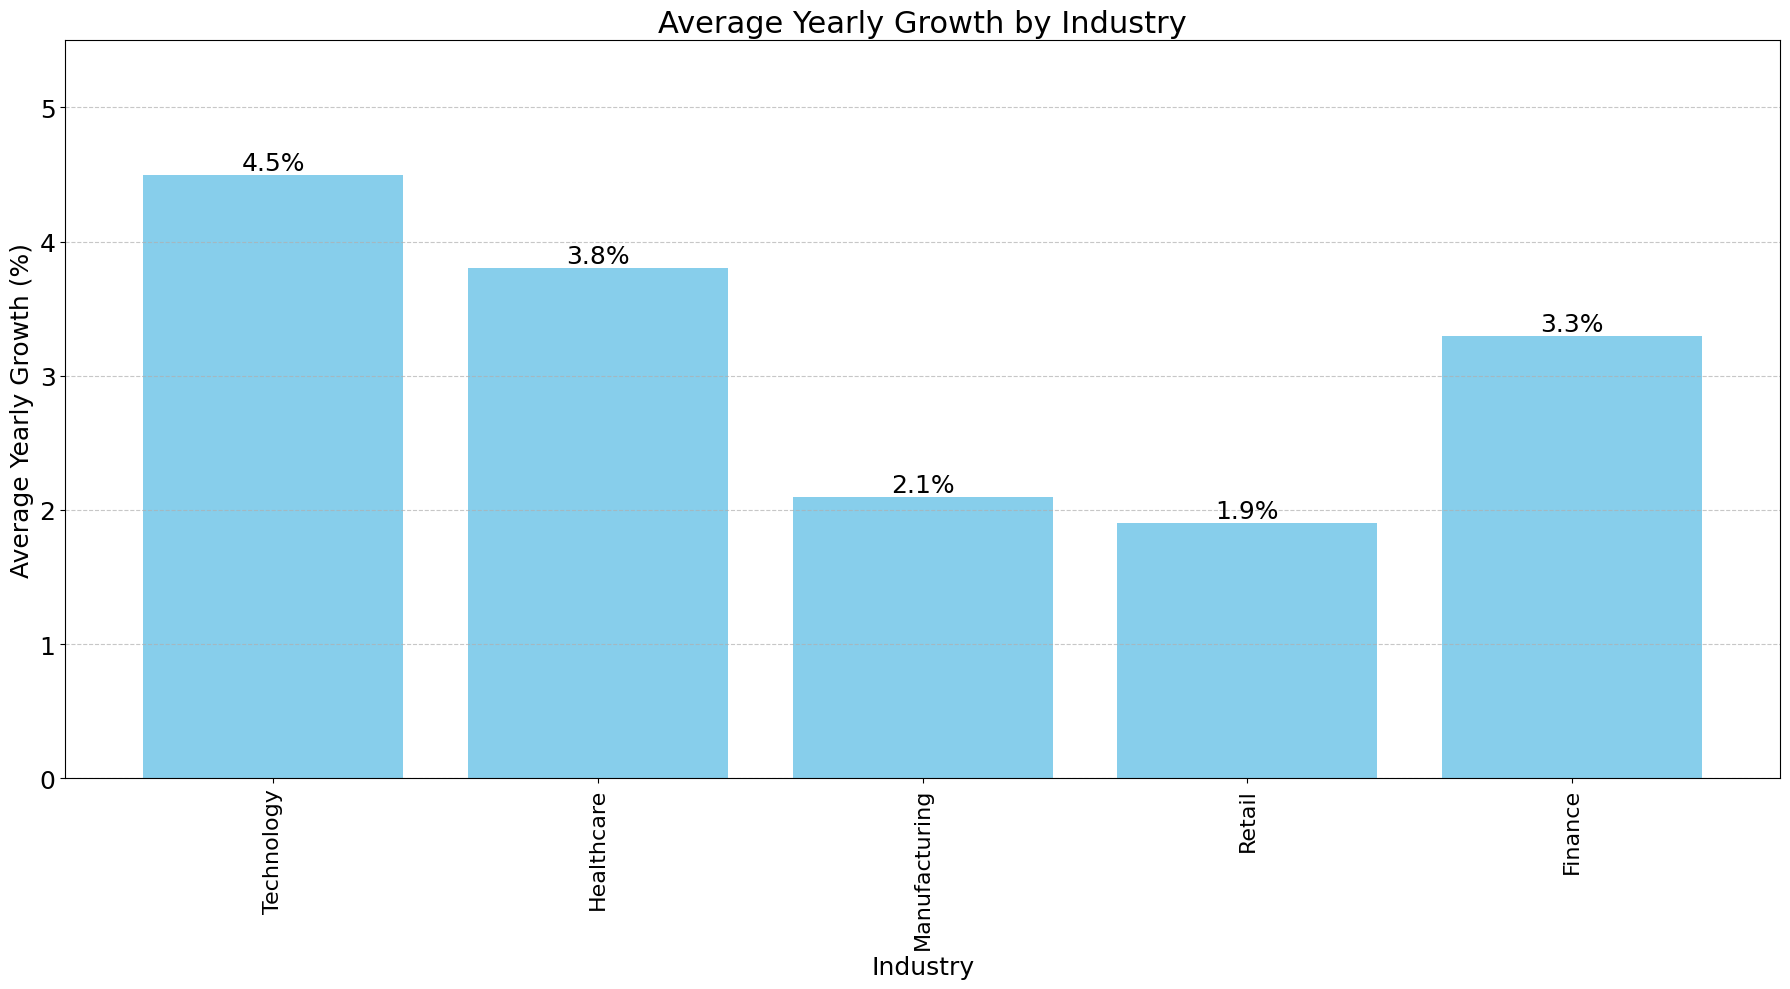

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Example data in case actual data is unavailable
industries = ["Technology", "Healthcare", "Manufacturing", "Retail", "Finance"]
#industries = ["Miscellaneous","Healthcare and Medical","Technology", "Healthcare", "Manufacturing", "Retail", "Finance","Government and Public Policy","Retail and Consumer Goods","Education and Training","Transportation and Logistics"]
average_growth = [4.5, 3.8, 2.1, 1.9, 3.3]  # Average yearly growth percentages

# Creating a DataFrame
data_for_plot = pd.DataFrame({"meta_industry": industries, "average_growth": average_growth})


font_size = 18

# Bar chart displaying the average yearly growth rate
plt.figure(figsize=(18, 10))
bars = plt.bar(data_for_plot["meta_industry"], data_for_plot["average_growth"], color="skyblue")

# Adding values above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.1f}%", ha='center', va='bottom', fontsize=font_size)

plt.xticks(rotation=90, fontsize=font_size-2)
plt.yticks(fontsize=font_size)
plt.title("Average Yearly Growth by Industry", fontsize=font_size+4)
plt.xlabel("Industry", fontsize=font_size)
plt.ylabel("Average Yearly Growth (%)", fontsize=font_size)
plt.ylim(0, max(data_for_plot["average_growth"]) + 1)  # Adjusting the scale
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the chart
plt.show()


%md
##Forecasting Growing Industries:

Using historical data to predict the expected number of profiles in various industries in the coming years.


07:29:34 - cmdstanpy - INFO - Chain [1] start processing
07:29:35 - cmdstanpy - INFO - Chain [1] done processing


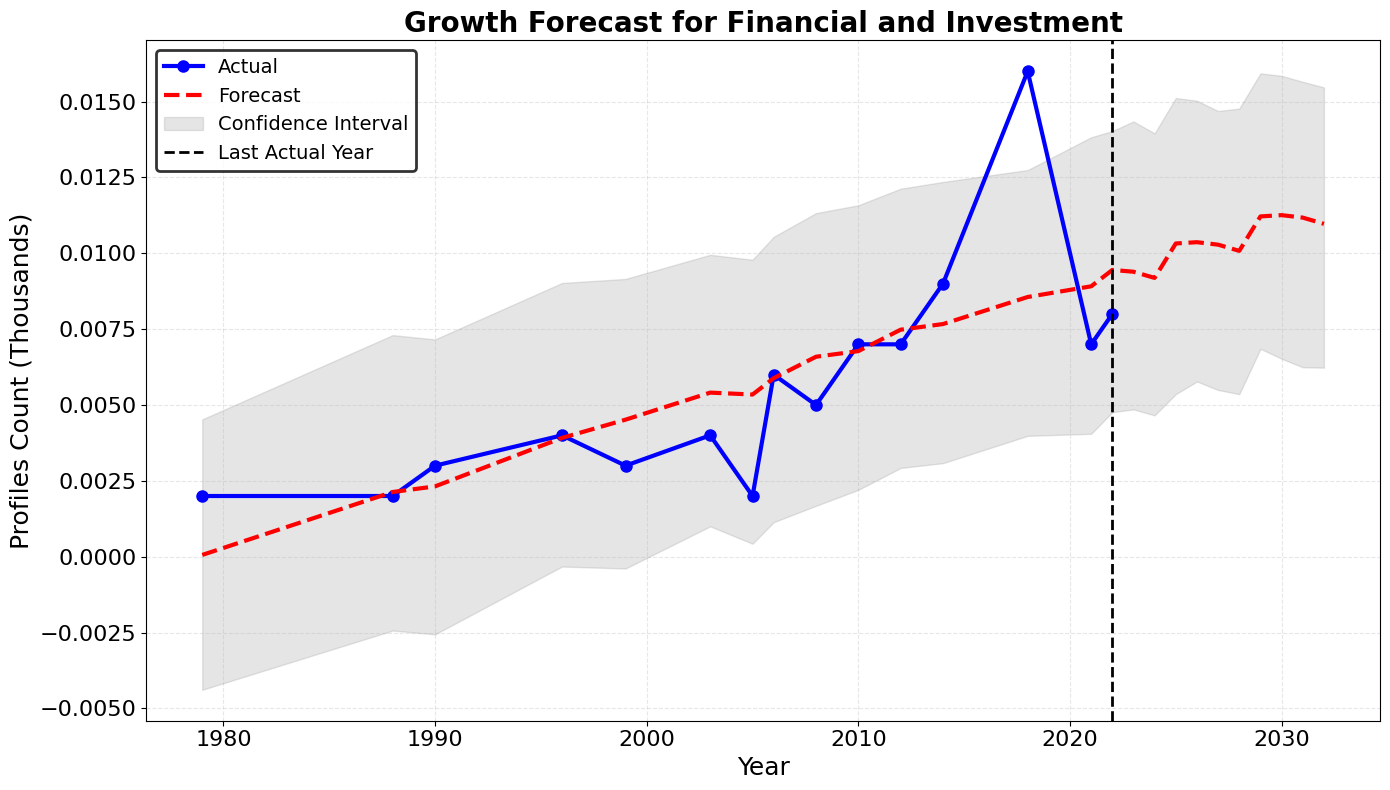

07:29:43 - cmdstanpy - INFO - Chain [1] start processing
07:29:43 - cmdstanpy - INFO - Chain [1] done processing


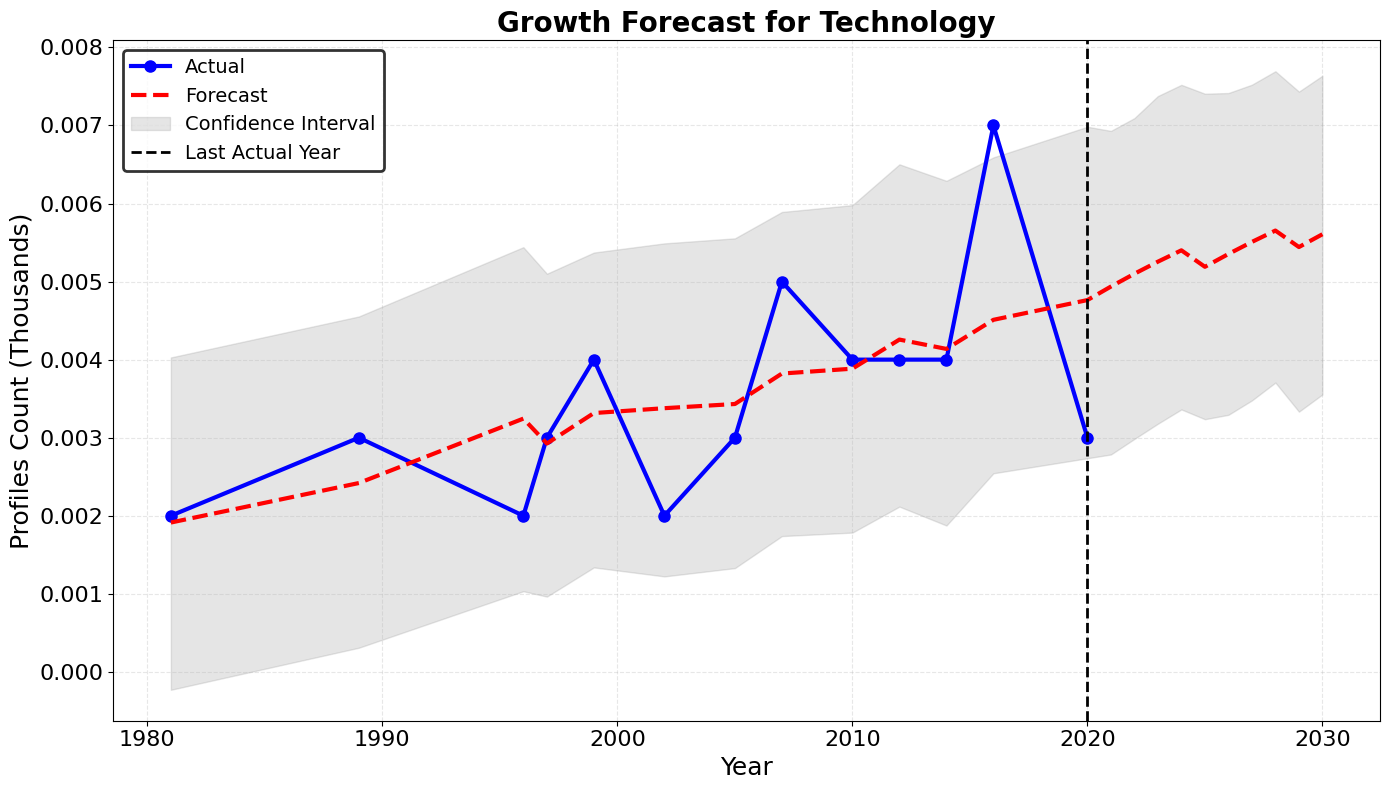

No data available for Healthcare and Medical, skipping.
No data available for Manufacturing, skipping.


In [0]:
from pyspark.sql.functions import col
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for Prophet
def prepare_data_for_prophet(industry_data, industry_name):
    """
    Prepares data for the Prophet model for a given industry.
    """
    data = industry_data.filter(col("meta_industry") == industry_name).select(
        col("start_year").alias("ds"), col("profiles_count").alias("y")
    ).toPandas()
    
    if data.empty:
        print(f"No data available for {industry_name}, skipping.")
        return None
    
    data["ds"] = pd.to_datetime(data["ds"], format="%Y")
    
    # Scale profile numbers to thousands for better readability in the graph
    data["y"] = data["y"] / 1000  
    
    return data

# Train Prophet model
def run_prophet_model(data):
    """
    Runs the Prophet model and generates a future forecast.
    """
    model = Prophet(yearly_seasonality=True, daily_seasonality=False, interval_width=0.95)
    model.fit(data)
    future = model.make_future_dataframe(periods=10, freq="Y")  # Forecast for 10 years ahead
    forecast = model.predict(future)
    return model, forecast

# Generate forecast plots
def plot_forecast(data, forecast, industry_name):
    """
    Plots actual and forecasted data for a given industry.
    """
    plt.figure(figsize=(14, 8))
    
    # Find the last actual data year
    last_data_year = data["ds"].max()
    
    # Line graph for actual data
    plt.plot(data["ds"], data["y"], marker="o", markersize=8, linestyle="-", linewidth=3, label="Actual", color="blue")
    
    # Line graph for forecasted data
    plt.plot(forecast["ds"], forecast["yhat"], linestyle="--", linewidth=3, label="Forecast", color="red")
    
    # Adding confidence interval for forecast
    plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], alpha=0.2, color="gray", label="Confidence Interval")

    # Adding a dashed vertical line to separate actual and forecasted data
    plt.axvline(x=last_data_year, color="black", linestyle="dashed", linewidth=2, label="Last Actual Year")

    # Formatting for better readability
    font_size = 18
    plt.title(f"Growth Forecast for {industry_name}", fontsize=font_size + 2, fontweight="bold")
    plt.xlabel("Year", fontsize=font_size)
    plt.ylabel("Profiles Count (Thousands)", fontsize=font_size)
    plt.xticks(fontsize=font_size - 2)
    plt.yticks(fontsize=font_size - 2)
    
    # Adjusting legend
    legend = plt.legend(fontsize=font_size - 4, loc="upper left")
    legend.get_frame().set_linewidth(2)
    legend.get_frame().set_edgecolor("black")

    # Adding soft grid lines for better visibility
    plt.grid(alpha=0.3, linestyle="--")

    plt.tight_layout()
    plt.show()

# Forecasting for top growing industries
top_industries = ["Financial and Investment", "Technology", "Healthcare and Medical", "Manufacturing"]

for industry in top_industries:
    industry_data = prepare_data_for_prophet(growing_industries, industry)
    if industry_data is not None and len(industry_data) >= 3:  # Ensure sufficient data points
        model, forecast = run_prophet_model(industry_data)
        plot_forecast(industry_data, forecast, industry)


#Prophet Explanation:


Forecasting Growth for Selected Industries
We used the Prophet model to forecast growth for dominant industries over the next three years. Here's the approach:

Data Preparation:

Filtered industries of interest: Services, Real Estate and Construction, and Retail and Consumer Goods.
Converted the data into a time-series format (ds for date and y for profiles count).
Prophet Model:

Configured with yearly_seasonality=True to capture annual trends.
Fitted the model to each industry's data and predicted growth for the next three years.
Visualization:

Combined actual and forecasted data in a single plot.
Confidence intervals (yhat_lower and yhat_upper) were included to show prediction uncertainty.
Each industry was clearly labeled for easy comparison.
The resulting graph allows HR teams and strategists to visualize industry trends and focus on sectors with significant growth potential.

%md
#6
What are the most common career paths for specific job roles?
Why is this important?
Helps users understand which roles commonly lead to their desired job.
Provides personalized career advice on the best steps to take.
How to analyze?
Extract previous job positions and analyze common transitions between roles.

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, count, explode

# Exploding the experience array to get individual job records
exploded_profiles = profiles.withColumn("exploded_experience", explode("experience"))

# Creating a window to analyze career transitions per user
career_window = Window.partitionBy("id").orderBy("exploded_experience.start_date")

# Adding a column for the previous position each user held
career_paths = exploded_profiles.withColumn(
    "prev_position", lag("exploded_experience.title").over(career_window)
)

# Counting how many times each transition occurred
career_transitions = career_paths.groupBy("prev_position", "exploded_experience.title") \
    .count().orderBy(col("count").desc())

# Displaying the most common career transitions
career_transitions.show(20, truncate=False)


+-------------+-------------------------------+------+
|prev_position|title                          |count |
+-------------+-------------------------------+------+
|NULL         |NULL                           |483297|
|NULL         |Owner                          |56658 |
|NULL         |Retired                        |18507 |
|NULL         |President                      |17339 |
|NULL         |Teacher                        |17042 |
|NULL         |Manager                        |12332 |
|NULL         |Administrative Assistant       |10479 |
|NULL         |retired                        |10224 |
|NULL         |owner                          |9571  |
|NULL         |Office Manager                 |8639  |
|NULL         |Project Manager                |8145  |
|NULL         |Intern                         |8010  |
|NULL         |Sales Associate                |7990  |
|NULL         |Registered Nurse               |7689  |
|NULL         |General Manager                |6868  |
|NULL     

In [0]:
from pyspark.sql.functions import explode, col

profiles_expanded = profiles.withColumn("experience", explode("experience"))

# extract relevan info
experience_df = profiles_expanded.select(
    col("id").alias("profile_id"),
    col("experience.title").alias("experience_title"),
    col("experience.description").alias("experience_description"),
    col("experience.start_date").alias("start_date"),
    col("experience.end_date").alias("end_date"),
    col("current_company.industry").alias("current_industry"),
).na.drop(subset=["experience_title", "start_date"])

experience_df.show(5)


+--------------------+--------------------+----------------------+----------+--------+--------------------+
|          profile_id|    experience_title|experience_description|start_date|end_date|    current_industry|
+--------------------+--------------------+----------------------+----------+--------+--------------------+
|glenn-wagner-3668...|             retired|                  NULL|  Jun 1992| Present|Michigan Conferen...|
|stephen-hockenbar...|System Administrator|                  NULL|  Aug 2022| Present|Blue Cross and Bl...|
|megan-dorsey-7ab6...|        Soccer Coach|                  NULL|  Sep 2021|May 2023|       Fat Beet Farm|
|megan-dorsey-7ab6...|Climate and Food ...|  Topics Discussed:...|  Jul 2021|Jul 2021|       Fat Beet Farm|
|megan-dorsey-7ab6...|Food Sustainabili...|                  NULL|  Aug 2020|Jul 2021|       Fat Beet Farm|
+--------------------+--------------------+----------------------+----------+--------+--------------------+
only showing top 5 rows



##Filtering and Ranking Job Titles

In [0]:

"""
Print Top 300 Cleaned Job Titles After Removing Specified Noise Words 
and Filtering Out Single-Token Titles
"""

from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# 1. Define the Noise Word List (Avoid Extra Generic Words)

job_title_noise_words = [
    # Experience level descriptors
    "junior", "senior", "entry", "mid", "expert", "associate", "lead", "principal",
    "chief", "executive", "apprentice", "novice", "intermediate", "advanced",
    "specialist", "consultant", "fellow", "master", "guru", "wizard", "authority",
    "veteran", "trainee", "intern", "pro", "seasoned", "skilled", "unskilled",

    # Management/Leadership Titles
    "manager", "director", "vp", "vice", "president", "ceo", "cto", "cfo", "coo", "cmo",
    "chairman", "supervisor", "coordinator", "officer", "head", "team", "administrator",
    "partner", "owner", "founder", "co-founder", "leadership", "chief", "executive",
    "board", "chair", "delegate", "representative",

    # General Descriptors (Not Job-Specific)
    "general", "generalist", "hybrid", "cross-functional", "multi-disciplinary",
    "solutionist", "innovator", "creator", "evangelist", "visionary", "pioneer",
    "disruptor", "change", "agent", "strategist", "advisor", "facilitator",
    "ambassador", "enthusiast", "advocate", "thought", "speaker", "trainer",
    "mentor", "coach", "builder", "improver", "enhancer", "specialist",

    # Common Extra Words
    "certified", "seniority", "juniority", "seasoned", "experienced", "skilled",
    "professional", "freelance", "contract", "permanent", "temporary", "entry-level",
    "mid-level", "full-time", "part-time", "remote", "onsite", "home-based",

    # Generic/Non-Informative Words
    "member", "staff", "associate", "contributor", "employee", "worker", "personnel",
    "representative", "resource", "operative", "agent", "officer", "executive",
    "delegate", "liaison", "official", "crew", "fellow", "peer", "volunteer",
    "participant", "member", "role", "position"
]

# Convert noise words list to a set for efficient lookup
noise_set = set(word.lower() for word in job_title_noise_words)

# 2. Define UDF to Remove Noise Words from Job Titles
def remove_noise_words(title: str) -> str:
    """
    Removes specified noise words from a job title.
    - Splits the title into words
    - Filters out noise words
    - Returns the cleaned title as a string
    """
    if not title:
        return ""
    tokens = title.split()
    filtered_tokens = [t for t in tokens if t.lower() not in noise_set]
    return " ".join(filtered_tokens)

remove_noise_words_udf = F.udf(remove_noise_words, StringType())

# 3. Apply UDF to Clean Job Titles in DataFrame

# Assume your original DataFrame is `experience_df`
experience_df_cleaned = experience_df.withColumn(
    "experience_title_clean", remove_noise_words_udf(F.col("experience_title"))
)

# Replace original column with cleaned version
experience_df_cleaned = experience_df_cleaned.drop("experience_title") \
                                             .withColumnRenamed("experience_title_clean", "experience_title")

# 4. Filter Out Rows with Empty or Single-Token Titles

experience_df_cleaned = experience_df_cleaned.filter(
    (F.col("experience_title").isNotNull()) &  # Ensure title is not null
    (F.trim(F.col("experience_title")) != "") &  # Remove empty strings
    (F.size(F.split(F.col("experience_title"), "\s+")) > 1)  # Keep only multi-word titles
)

# 5. Group by Cleaned Job Title and Print Top 300
common_titles_df = (
    experience_df_cleaned
    .groupBy(F.lower(F.col("experience_title")).alias("job_title_lower"))
    .agg(F.count("*").alias("count"))
    .orderBy(F.desc("count"))
    .limit(300)
)

# Show the top 300 most common cleaned job titles
common_titles_df.show(300, truncate=False)


+--------------------------------+-----+
|job_title_lower                 |count|
+--------------------------------+-----+
|customer service                |27749|
|software engineer               |23914|
|administrative assistant        |23179|
|registered nurse                |15252|
|research assistant              |14761|
|human resources                 |10620|
|graphic designer                |10038|
|business development            |9775 |
|real estate                     |7592 |
|medical assistant               |6074 |
|substitute teacher              |6073 |
|of operations                   |6012 |
|teaching assistant              |6011 |
|software developer              |5983 |
|pharmacy technician             |5184 |
|office assistant                |5164 |
|business analyst                |5039 |
|project engineer                |5019 |
|front desk                      |4896 |
|legal assistant                 |4742 |
|financial analyst               |4664 |
|social media   

##Prophet-Based Job Market Forecasting

choose the number of top jobs to see prediction and forecast period

In [0]:
num_top_jobs = 2
forecast_period_months = 36

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcoodk8ph/7_g13ysi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcoodk8ph/c4g_xgu_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/databricks/python3/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23485', 'data', 'file=/tmp/tmpcoodk8ph/7_g13ysi.json', 'init=/tmp/tmpcoodk8ph/c4g_xgu_.json', 'output', 'file=/tmp/tmpcoodk8ph/prophet_modelgl6xy77p/prophet_model-20250206074921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

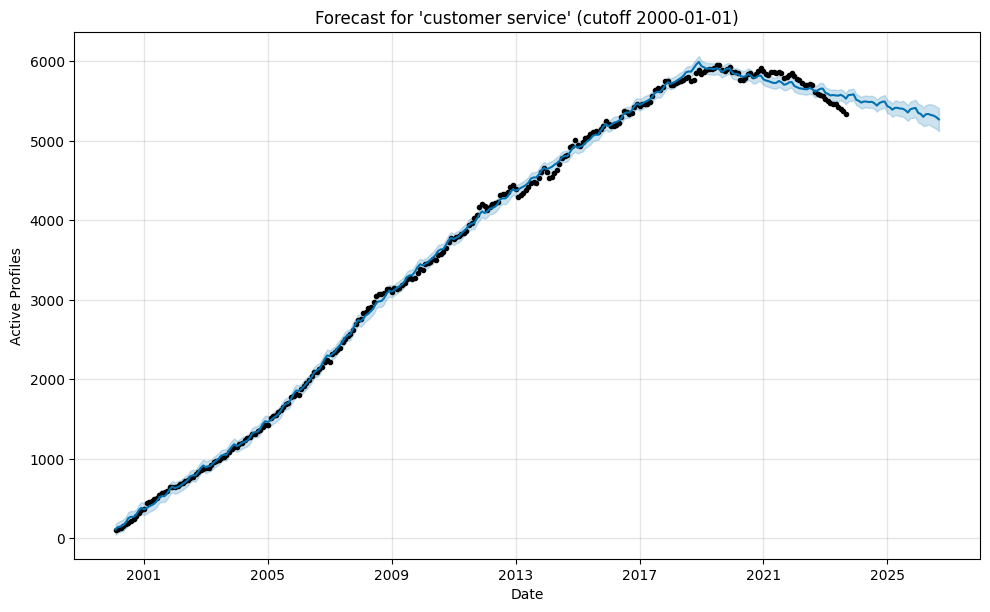

<Figure size 1000x600 with 0 Axes>

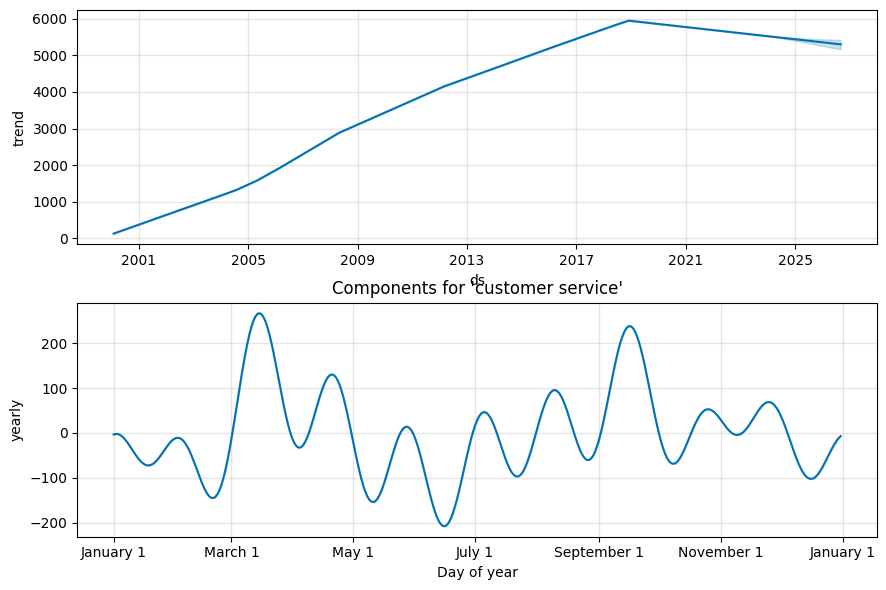

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcoodk8ph/cpcz_zqf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcoodk8ph/vak0xtih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/databricks/python3/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68977', 'data', 'file=/tmp/tmpcoodk8ph/cpcz_zqf.json', 'init=/tmp/tmpcoodk8ph/vak0xtih.json', 'output', 'file=/tmp/tmpcoodk8ph/prophet_modelfrjhvjur/prophet_model-20250206075001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:50:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:50:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

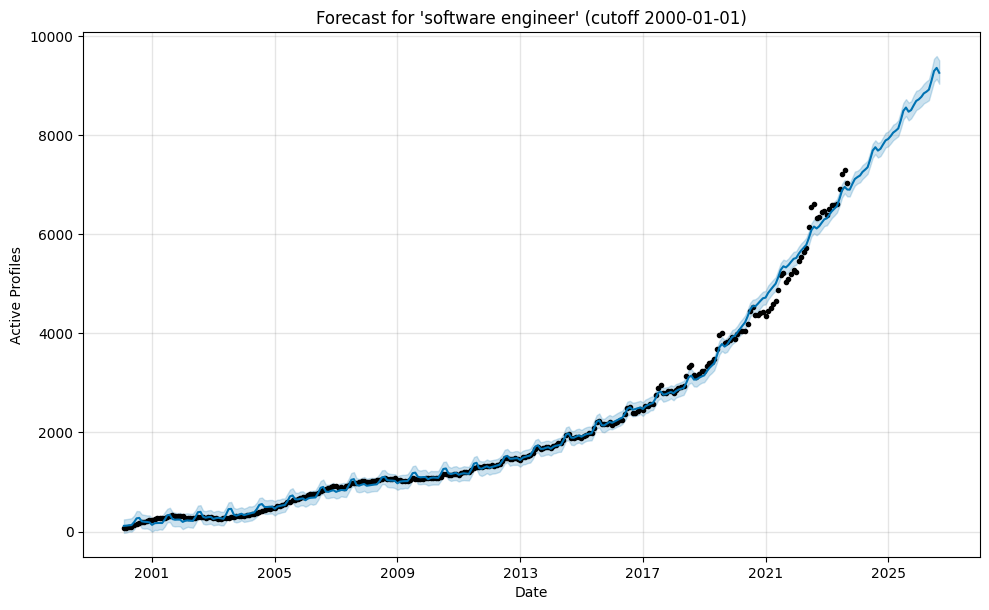

<Figure size 1000x600 with 0 Axes>

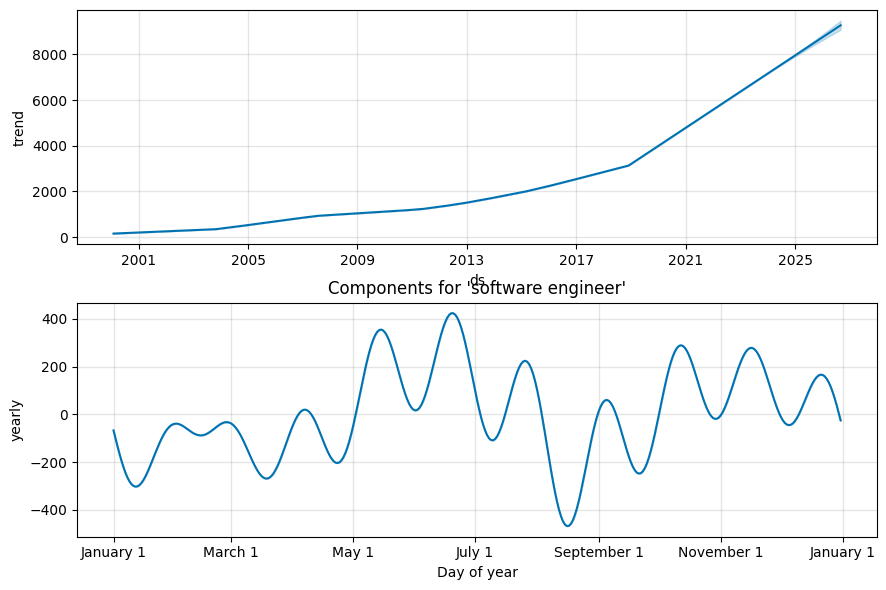

In [0]:
import pyspark.sql.functions as F
from pyspark.sql.types import DateType
from pyspark.sql.window import Window
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime

# 1. Define a UDF to Parse Date Strings
def parse_date(date_str: str):
    """
    Attempts to parse a date string using multiple formats.
    Returns a date (not datetime) if successful, otherwise None.
    """
    if not date_str:
        return None
    date_str = date_str.strip()
    # Attempt various patterns, e.g., "Sep 2019", "September 2019", "2015"
    formats = ["%b %Y", "%B %Y", "%Y"]
    for fmt in formats:
        try:
            dt = datetime.strptime(date_str, fmt)
            return dt.date()
        except Exception:
            continue
    return None

parse_date_udf = F.udf(parse_date, DateType())

# 2. User Variables
cutoff_date_str = "2000-01-01"  # Adjust or remove if you want all data

# ============================
# 3. Determine Top x Job Titles by Frequency
# ============================
title_counts_df = (
    experience_df_cleaned
    .groupBy(F.lower(F.col("experience_title")).alias("job_title_lower"))
    .agg(F.count("*").alias("appearances"))
    .orderBy(F.desc("appearances"))
    .limit(num_top_jobs)
)
top_titles = [row["job_title_lower"] for row in title_counts_df.collect()]

# ============================
# 4. Loop Over Each Top Title & Forecast
# ============================
for job_title in top_titles:
    filtered_df = experience_df_cleaned.filter(
        F.lower(F.col("experience_title")).like(f"%{job_title}%")
    )
    
    # Convert date columns using our parse_date UDF
    filtered_df = (
        filtered_df
        .withColumn("start_date_parsed", parse_date_udf(F.col("start_date")))
        .withColumn("end_date_parsed",   parse_date_udf(F.col("end_date")))
    )
    
    # Drop old columns and rename parsed columns
    filtered_df = (
        filtered_df
        .drop("start_date", "end_date")
        .withColumnRenamed("start_date_parsed", "start_date")
        .withColumnRenamed("end_date_parsed",   "end_date")
    )
    
    # Compute how many joined/left per date
    joined_df = (
        filtered_df
        .groupBy("start_date")
        .agg(F.countDistinct("profile_id").alias("joined_profiles"))
        .withColumnRenamed("start_date", "date")
    )
    left_df = (
        filtered_df
        .groupBy("end_date")
        .agg(F.countDistinct("profile_id").alias("left_profiles"))
        .withColumnRenamed("end_date", "date")
    )
    
    # Merge joined & left counts
    full_df = (
        joined_df
        .join(left_df, on="date", how="outer")
        .fillna(0)
        .filter(F.col("date").isNotNull())
        .orderBy("date")
    )
    
    # (Optional) Filter by cutoff date
    filtered_full_df = full_df.filter(F.col("date") >= cutoff_date_str)
    
    # If empty, revert to all available data
    if filtered_full_df.rdd.isEmpty():
        filtered_full_df = full_df

    # Calculate active profiles = cumulative joined - cumulative left
    window_spec = Window.orderBy("date").rowsBetween(Window.unboundedPreceding, -1)
    filtered_full_df = (
        filtered_full_df
        .withColumn("cumulative_joined", F.sum("joined_profiles").over(window_spec))
        .withColumn("cumulative_left",   F.sum("left_profiles").over(window_spec))
        .withColumn("active_profiles",   F.col("cumulative_joined") - F.col("cumulative_left"))
        .select("date", "active_profiles")
    )
    
    # Convert to Pandas for Prophet
    df_pandas = filtered_full_df.toPandas()
    df_pandas.rename(columns={"date": "ds", "active_profiles": "y"}, inplace=True)
    df_pandas["ds"] = pd.to_datetime(df_pandas["ds"], errors="coerce")
    df_pandas.dropna(subset=["ds"], inplace=True)
    df_pandas.sort_values("ds", inplace=True)
    
    # Check data sufficiency
    if len(df_pandas) < 2 or df_pandas["ds"].nunique() < 2 or df_pandas["y"].dropna().shape[0] < 2:
        continue
    
    # Fit Prophet model
    model = Prophet()
    model.fit(df_pandas)
    
    # Forecast
    future = model.make_future_dataframe(periods=forecast_period_months, freq="M")
    forecast = model.predict(future)
    
    # Plot forecast
    plt.figure(figsize=(10, 6))
    model.plot(forecast)
    plt.title(f"Forecast for '{job_title}' (cutoff {cutoff_date_str})")
    plt.xlabel("Date")
    plt.ylabel("Active Profiles")
    plt.grid(True)
    plt.show()
    
    # Plot components
    plt.figure(figsize=(10, 6))
    model.plot_components(forecast)
    plt.title(f"Components for '{job_title}'")
    plt.show()


insert your choose title here and forecast period

In [0]:
forecast_period_months = 12
chosen_title = "customer service"

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcoodk8ph/06e2nz4d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcoodk8ph/edga8cij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/databricks/python3/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54969', 'data', 'file=/tmp/tmpcoodk8ph/06e2nz4d.json', 'init=/tmp/tmpcoodk8ph/edga8cij.json', 'output', 'file=/tmp/tmpcoodk8ph/prophet_modelmi04i82_/prophet_model-20250206074640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

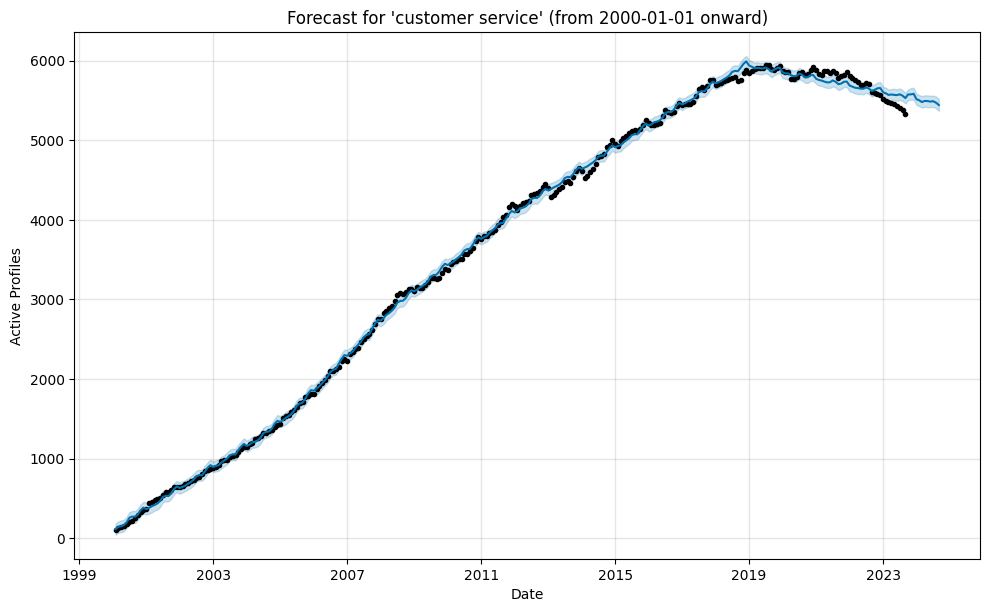

<Figure size 1000x600 with 0 Axes>

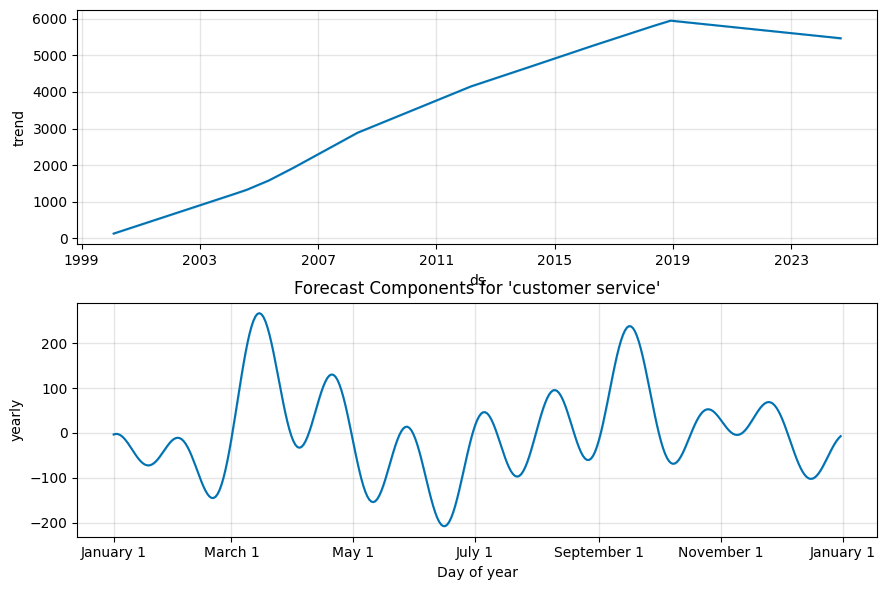

In [0]:
import pyspark.sql.functions as F
from pyspark.sql.types import DateType
from pyspark.sql.window import Window
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime

# -------------------------------
# 1. Define a UDF to Parse Date Strings
# -------------------------------
def parse_date(date_str: str):
    """
    Attempts to parse a date string using multiple formats.
    Returns a date (not datetime) if successful, otherwise None.
    """
    if not date_str:
        return None
    date_str = date_str.strip()
    formats = ["%b %Y", "%B %Y", "%Y"]  
    for fmt in formats:
        try:
            dt = datetime.strptime(date_str, fmt)
            return dt.date()
        except Exception:
            continue
    return None

parse_date_udf = F.udf(parse_date, DateType())

# -------------------------------
# 2. User Variables
# -------------------------------
cutoff_date_str = "2000-01-01"       # Use this cutoff date (adjust as needed)
    

# -------------------------------
# 3. Filter Data for the Chosen Job Title
# -------------------------------
filtered_df = experience_df_cleaned.filter(
    F.lower(F.col("experience_title")).like(f"%{chosen_title.lower()}%")
)

# -------------------------------
# 4. Convert Date Columns Using the UDF
# -------------------------------
filtered_df = (
    filtered_df
    .withColumn("start_date_parsed", parse_date_udf(F.col("start_date")))
    .withColumn("end_date_parsed",   parse_date_udf(F.col("end_date")))
)
filtered_df = filtered_df.drop("start_date", "end_date") \
                         .withColumnRenamed("start_date_parsed", "start_date") \
                         .withColumnRenamed("end_date_parsed",   "end_date")

# -------------------------------
# 5. Compute Joined and Left Counts by Date
# -------------------------------
joined_df = (
    filtered_df
    .groupBy("start_date")
    .agg(F.countDistinct("profile_id").alias("joined_profiles"))
    .withColumnRenamed("start_date", "date")
)
left_df = (
    filtered_df
    .groupBy("end_date")
    .agg(F.countDistinct("profile_id").alias("left_profiles"))
    .withColumnRenamed("end_date", "date")
)

# -------------------------------
# 6. Merge Joined and Left Data
# -------------------------------
full_df = (
    joined_df
    .join(left_df, on="date", how="outer")
    .fillna(0)
    .filter(F.col("date").isNotNull())
    .orderBy("date")
)

# -------------------------------
# 7. (Optional) Filter Data by Cutoff Date
# -------------------------------
# Remove or adjust the following line if you want to use all available data.
full_df = full_df.filter(F.col("date") >= cutoff_date_str)

# -------------------------------
# 8. Calculate Active Profiles Using Cumulative Sums
# -------------------------------
window_spec = Window.orderBy("date").rowsBetween(Window.unboundedPreceding, -1)
full_df = (
    full_df
    .withColumn("cumulative_joined", F.sum("joined_profiles").over(window_spec))
    .withColumn("cumulative_left",   F.sum("left_profiles").over(window_spec))
    .withColumn("active_profiles",   F.col("cumulative_joined") - F.col("cumulative_left"))
    .select("date", "active_profiles")
)

# -------------------------------
# 9. Convert to Pandas for Prophet
# -------------------------------
df_pandas = full_df.toPandas()
df_pandas.rename(columns={"date": "ds", "active_profiles": "y"}, inplace=True)
df_pandas["ds"] = pd.to_datetime(df_pandas["ds"], errors="coerce")
df_pandas.dropna(subset=["ds"], inplace=True)
df_pandas.sort_values("ds", inplace=True)

# Ensure there is enough data to fit Prophet
if len(df_pandas) < 2 or df_pandas["ds"].nunique() < 2 or df_pandas["y"].dropna().shape[0] < 2:
    raise ValueError(f"Insufficient data for forecasting '{chosen_title}'.")

# -------------------------------
# 10. Fit the Prophet Model and Forecast
# -------------------------------
model = Prophet()
model.fit(df_pandas)
future = model.make_future_dataframe(periods=forecast_period_months, freq="M")
forecast = model.predict(future)

# -------------------------------
# 11. Plot the Forecast and Components
# -------------------------------
plt.figure(figsize=(10, 6))
model.plot(forecast)
plt.title(f"Forecast for '{chosen_title}' (from {cutoff_date_str} onward)")
plt.xlabel("Date")
plt.ylabel("Active Profiles")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
model.plot_components(forecast)
plt.title(f"Forecast Components for '{chosen_title}'")
plt.show()
